## IA376-L - Projeto Final - Data Augmentation

Clonando o repositório para pegar a GAN e o GradCAM.

In [ ]:
!git clone https://github.com/pfracarolli/ia376l.git

Cloning into 'ia376l'...
remote: Enumerating objects: 225, done.
remote: Counting objects: 100% (225/225), done.
remote: Compressing objects: 100% (130/130), done.
remote: Total 225 (delta 105), reused 210 (delta 90), pack-reused 0
Receiving objects: 100% (225/225), 26.37 MiB | 24.15 MiB/s, done.
Resolving deltas: 100% (105/105), done.


Instalando o repositório como uma biblioteca.

In [ ]:
!pip uninstall -y ia376l
!cd ./ia376l && pip install .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/ia376l
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 585 kB 9.5 MB/s 
     |████████████████████████████████| 596 kB 80.4 MB/s 
     |████████████████████████████████| 419 kB 90.5 MB/s 
     |████████████████████████████████| 140 kB 94.2 MB/s 
     |████████████████████████████████| 1.1 MB 82.9 MB/s 
     |████████████████████████████████| 144 kB 88.6 MB/s 
     |████████████████████████████████| 94 kB 3.8 MB/s 
     |████████████████████████████████| 271 kB 61.9 MB/s 
  Created wheel f

Baixando e descomprimindo o dataset.

In [ ]:
!mkdir ./data && cp ./drive/MyDrive/FotosModelo.zip ./data/FotosModelo.zip

In [ ]:
!cd ./data && unzip ./FotosModelo.zip > /dev/null && rm -rf ./FotosModelo.zip 

Criando uma função para setar todas as seeds para fins de reprodutibilidade.

In [ ]:
import torch
import numpy as np
import random

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

set_seed(1234)

Dividindo o dataset entre treino, validação e teste.

In [ ]:
import os
import shutil

!rm -rf ./data_split
set_seed(1234)

def write_lines_into_file(filepath, lines):
    if not os.path.exists(filepath):
        with open(filepath, 'w') as f:
            for line in lines:
                f.write(f'{line}\n')

def split_dataset(root_dir: str, dist_dir: str, train_size: float = .7, split_dir='./drive/MyDrive/checkpoints'):
    train_dir = f"{dist_dir}/train"
    val_dir = f"{dist_dir}/validation"
    test_dir = f"{dist_dir}/test"

    if not os.path.exists(train_dir):
        os.makedirs(train_dir)

    if not os.path.exists(test_dir):
        os.makedirs(test_dir)

    if len(os.listdir(train_dir)) == 0 and len(os.listdir(test_dir)) == 0:
        for class_dir in os.listdir(root_dir):
            currclass_dir = f"{root_dir}/{class_dir}"

            currclass_train_dir = f"{train_dir}/{class_dir}"
            currclass_val_dir = f"{val_dir}/{class_dir}"
            currclass_test_dir = f"{test_dir}/{class_dir}"

            os.makedirs(currclass_train_dir)
            os.makedirs(currclass_val_dir)
            os.makedirs(currclass_test_dir)

            files = os.listdir(currclass_dir)
            np.random.shuffle(files)
            num_files = len(files)

            train_idx = int(num_files * train_size)
            val_idx = train_idx + int((num_files - train_idx) / 2)

            if not os.path.exists(f'{split_dir}/{class_dir}'):
                os.makedirs(f'{split_dir}/{class_dir}')

            train_filename = f'{split_dir}/{class_dir}/train.txt'
            validation_filename = f'{split_dir}/{class_dir}/validation.txt'
            test_filename = f'{split_dir}/{class_dir}/test.txt'

            write_lines_into_file(train_filename, files[:train_idx])
            write_lines_into_file(validation_filename, files[train_idx:val_idx])
            write_lines_into_file(test_filename, files[val_idx:])

            train_filenames = open(train_filename)
            validation_filenames = open(validation_filename)
            test_filenames = open(test_filename)

            for filename in train_filenames.readlines():
                shutil.copy(f"{currclass_dir}/{filename.strip()}", f"{currclass_train_dir}/{filename.strip()}")

            for filename in validation_filenames.readlines():
                shutil.copy(f"{currclass_dir}/{filename.strip()}", f"{currclass_val_dir}/{filename.strip()}")

            for filename in test_filenames.readlines():
                shutil.copy(f"{currclass_dir}/{filename.strip()}", f"{currclass_test_dir}/{filename.strip()}")

            train_filenames.close()
            validation_filenames.close()
            test_filenames.close()       

split_dataset('./data', './data_split')

Plotando o histograma das classes para verificar se estão balanceadas.

<BarContainer object of 10 artists>

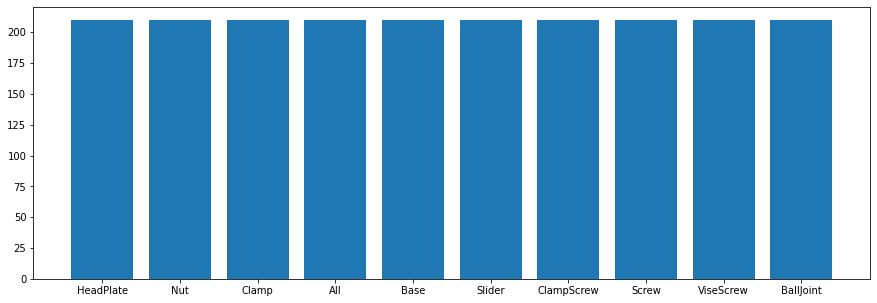

In [ ]:
import matplotlib.pyplot as plt

train_data = [
    (klass, len(os.listdir(f'./data_split/train/{klass}'))) 
    for klass in os.listdir('./data_split/train')
]

xs, ys = zip(*train_data)

ax = plt.subplot()
ax.figure.set_figheight(5)
ax.figure.set_figwidth(15)
ax.bar(xs, ys)

Criando os dataloaders de treino (sem augmentation), validação e teste.

In [ ]:
from multiprocessing import cpu_count

from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, ToPILImage, Compose, Resize

ds_transform=Compose([ToTensor(), Resize((512, 512))])
ds_train = ImageFolder('./data_split/train', transform=ds_transform)
ds_validation = ImageFolder('./data_split/validation', transform=ds_transform)
ds_test = ImageFolder('./data_split/test', transform=ds_transform)

print('# of train examples', len(ds_train))
print('# of validation examples', len(ds_validation))
print('# of test examples', len(ds_test))

batch_size = 20

dl_train = DataLoader(ds_train, batch_size, shuffle=True, num_workers=cpu_count())
dl_validation = DataLoader(ds_validation, batch_size, shuffle=False, num_workers=cpu_count())
dl_test = DataLoader(ds_test, batch_size, shuffle=False, num_workers=cpu_count())

x, y = next(iter(dl_train))

print(x.size())
print(y.size())

# of train examples 2100
# of validation examples 450
# of test examples 450
torch.Size([20, 3, 512, 512])
torch.Size([20])


Aqui, criamos uma função para criar um objeto `Trainer` do `pytorch_lightning`. Criamos a função para passar os argumentos dinamicamente, pois se passarmos `resume_from_checkpoint` sem ter o arquivo existir iremos ter um erro.

In [ ]:
import pytorch_lightning as pl

def create_trainer(checkpoint_path: str, filename: str, max_epochs: int = 25) -> pl.Trainer:
    trainer_kwargs = {
        'gpus': 1,
        'max_epochs': max_epochs,
    }

    trainer_kwargs['callbacks'] = [
        pl.callbacks.ModelCheckpoint(
            dirpath=checkpoint_path, 
            filename=filename,
            every_n_epochs=1,
            save_top_k=1,
            monitor='validation_acc',
            mode='max'
        )
    ]

    checkpoint_full_path = os.path.join(checkpoint_path, f'{filename}.ckpt')

    if os.path.exists(checkpoint_full_path):
        trainer_kwargs['resume_from_checkpoint'] = checkpoint_full_path

    return pl.Trainer(**trainer_kwargs)

Treinamento dos modelos. Por enquanto, estamos apenas testando os checkpoints encontrados. Para repetir os treinamentos e a geração de dados, descomente as linhas comentadas e comente as linhas que carregam os modelos a partir do checkpoint (i.e. `MobileNet.load_from_checkpoint(...)`).

In [ ]:
from ia376l.models import MobileNet

set_seed(1234)

model_base = MobileNet()
trainer = create_trainer('./drive/MyDrive/checkpoints/', 'baseline_2') 
# trainer.fit(model_base, train_dataloaders=dl_train, val_dataloaders=dl_validation)
model_base = MobileNet.load_from_checkpoint('./drive/MyDrive/checkpoints/baseline_2.ckpt')
trainer.test(model_base, dl_test)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:52: LightningDeprecationWarning: Setting `Trainer(resume_from_checkpoint=)` is deprecated in v1.5 and will be removed in v1.7. Please pass `Trainer.fit(ckpt_path=)` directly instead.
  "Setting `Trainer(resume_from_checkpoint=)` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /content/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.791304347826087
        train_acc           0.7977777777777778
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.791304347826087, 'train_acc': 0.7977777777777778}]

In [ ]:
# !rm -rf ./data_split/train_gen_25
# !cp -r ./data_split/train ./data_split/train_gen_25

In [ ]:
import gc

from tqdm.notebook import tqdm
from torchvision.utils import save_image
from ia376l.models import Generator

set_seed(1234)

def generate_samples(generator, train_data_root, weights_root, gen_size=0.25):
    for folder in tqdm(os.listdir(train_data_root)):
        output_folder = f"{train_data_root}/{folder}"
        n = int(len(os.listdir(output_folder)) * gen_size)
        weights = torch.load(f"{weights_root}/{folder}.pth")
        generator.load_state_dict(weights['gen_state_dict'])
        generator.eval()
        
        for idx in range(n):
            batch = generator(torch.randn(1, 256, 1, 1))
            image = batch[0]
            save_image(image, f'{output_folder}/{folder}_gen_{idx}.png', normalize=True)

        gc.collect()

# print('Generating samples...')
# generate_samples(Generator(), './data_split/train_gen_25', './drive/MyDrive/PESOS', gen_size=0.25)

In [ ]:
set_seed(1234)

# ds_train_gen_25 = ImageFolder('./data_split/train_gen_25', transform=ds_transform)
# dl_train_gen_25 = DataLoader(
#     ds_train_gen_25, 
#     batch_size=batch_size, 
#     shuffle=True, 
#     num_workers=cpu_count()
# )

# print('# of training examples (with gen)', len(ds_train_gen_25))
# print(next(iter(dl_train_gen_25))[0].size())

In [ ]:
set_seed(1234)

model_gen_25 = MobileNet()
trainer = create_trainer('./drive/MyDrive/checkpoints/', 'augmented-25_2') 
# trainer.fit(model_gen_25, train_dataloaders=dl_train_gen_25, val_dataloaders=dl_validation)
model_gen_25 = MobileNet.load_from_checkpoint('./drive/MyDrive/checkpoints/augmented-25_2.ckpt')
trainer.test(model_gen_25, dl_test)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:52: LightningDeprecationWarning: Setting `Trainer(resume_from_checkpoint=)` is deprecated in v1.5 and will be removed in v1.7. Please pass `Trainer.fit(ckpt_path=)` directly instead.
  "Setting `Trainer(resume_from_checkpoint=)` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7217391304347825
        train_acc                  0.72
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.7217391304347825, 'train_acc': 0.72}]

In [ ]:
# !rm -rf ./data_split/train_gen_75
# !cp -r ./data_split/train ./data_split/train_gen_75

# set_seed(1234)

# print('Generating samples...')
# generate_samples(Generator(), './data_split/train_gen_75', './drive/MyDrive/PESOS', gen_size=0.75)

In [ ]:
# set_seed(1234)

# ds_train_gen_75 = ImageFolder('./data_split/train_gen_75', transform=ds_transform)
# dl_train_gen_75 = DataLoader(
#     ds_train_gen_75, 
#     batch_size=batch_size, 
#     shuffle=True, 
#     num_workers=cpu_count()
# )

# print('# of training examples (with gen)', len(ds_train_gen_75))
# print(next(iter(dl_train_gen_75))[0].size())

In [ ]:
set_seed(1234)

model_gen_75 = MobileNet()

trainer = create_trainer('./drive/MyDrive/checkpoints/', 'augmented-75_2') 
# trainer.fit(model_gen_75, train_dataloaders=dl_train_gen_75, val_dataloaders=dl_validation)
model_gen_75 = MobileNet.load_from_checkpoint('./drive/MyDrive/checkpoints/augmented-75_2.ckpt')
trainer.test(model_gen_75, dl_test)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:52: LightningDeprecationWarning: Setting `Trainer(resume_from_checkpoint=)` is deprecated in v1.5 and will be removed in v1.7. Please pass `Trainer.fit(ckpt_path=)` directly instead.
  "Setting `Trainer(resume_from_checkpoint=)` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8369565217391303
        train_acc           0.8444444444444444
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.8369565217391303, 'train_acc': 0.8444444444444444}]

In [ ]:
# !rm -rf ./data_split/train_gen_125
# !cp -r ./data_split/train ./data_split/train_gen_125

# set_seed(1234)

# print('Generating samples...')
# generate_samples(Generator(), './data_split/train_gen_125', './drive/MyDrive/PESOS', gen_size=1.25)

In [ ]:
# set_seed(1234)

# ds_train_gen_125 = ImageFolder('./data_split/train_gen_125', transform=ds_transform)
# dl_train_gen_125 = DataLoader(
#     ds_train_gen_125, 
#     batch_size=batch_size, 
#     shuffle=True, 
#     num_workers=cpu_count()
# )

# print('# of training examples (with gen)', len(ds_train_gen_125))
# print(next(iter(dl_train_gen_125))[0].size())

In [ ]:
set_seed(1234)

model_gen_125 = MobileNet()
trainer = create_trainer('./drive/MyDrive/checkpoints/', 'augmented-125_2') 
# trainer.fit(model_gen_125, train_dataloaders=dl_train_gen_125, val_dataloaders=dl_validation)
model_gen_125 = MobileNet.load_from_checkpoint('./drive/MyDrive/checkpoints/augmented-125.ckpt')
trainer.test(model_gen_125, dl_test)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:52: LightningDeprecationWarning: Setting `Trainer(resume_from_checkpoint=)` is deprecated in v1.5 and will be removed in v1.7. Please pass `Trainer.fit(ckpt_path=)` directly instead.
  "Setting `Trainer(resume_from_checkpoint=)` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8239130434782609
        train_acc                  0.82
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.8239130434782609, 'train_acc': 0.82}]